<a href="https://colab.research.google.com/github/sugeng-riyanto/AdminLTE/blob/master/Complete_Model_TrainingX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Part 1: Importing Required Libraries

This section imports the necessary libraries for building and training your model, including TensorFlow, Keras, and other utilities.


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os



# Part 2: Mounting Google Drive

This step is specific to Google Colab. It mounts your Google Drive to access the dataset stored in it.


In [2]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive



# Part 4: Data Preprocessing

This section handles data preprocessing using `ImageDataGenerator`. It applies data augmentation to the training set and normalizes the test set.


[link text](https://drive.google.com/drive/folders/1mlrCnfg_KlGoB9M57gszOQvKfFfb0AqI?usp=sharing)

In [3]:
# Set up directories
train_dir = '/content/drive/My Drive/data/train'
test_dir = '/content/drive/My Drive/data/test'

# Data Preprocessing with Less Aggressive Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Reduced rotation range
    width_shift_range=0.1,  # Reduced width shift
    height_shift_range=0.1,  # Reduced height shift
    shear_range=0.1,  # Reduced shear range
    zoom_range=0.1,  # Reduced zoom range
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 80-20 split for training and validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Increase Batch Size to 64
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=64,  # Increased batch size
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=64,  # Increased batch size
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=64,  # Increased batch size
    class_mode='categorical'
)


Found 12000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 2160 images belonging to 15 classes.



# Part 5: Building the Model

Here, a Convolutional Neural Network (CNN) model is built. Batch normalization is added to stabilize learning, and dropout is applied to prevent overfitting.


In [4]:
# Building the Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')
])

# Compile the model with a reduced learning rate
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Reduced learning rate
    metrics=['accuracy']
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



# Part 6: Setting Up Callbacks

Custom callbacks are created to monitor training time and stop training when validation accuracy reaches 95%.


In [5]:
# Setting up callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)  # Adjusted min_lr
]


# Part 7: Initializing Callbacks

These callbacks are initialized and included in the model training process.


In [7]:
import time
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.mixed_precision import set_global_policy

# Enable mixed precision
set_global_policy('mixed_float16')

class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        time_taken = time.time() - self.start_time
        print(f"Time taken for epoch {epoch + 1}: {time_taken:.2f} seconds")

class StopTrainingAtMetrics(Callback):
    def __init__(self, target_acc=0.95, target_loss=0.2, target_val_acc=0.95):
        super(StopTrainingAtMetrics, self).__init__()
        self.target_acc = target_acc
        self.target_loss = target_loss
        self.target_val_acc = target_val_acc

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy')
        loss = logs.get('loss')
        val_accuracy = logs.get('val_accuracy')

        if accuracy >= self.target_acc and loss <= self.target_loss and val_accuracy >= self.target_val_acc:
            print(f"\nReached desired metrics: Accuracy: {accuracy:.4f}, Loss: {loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
            print("Stopping training!")
            self.model.stop_training = True

# Initialize the callbacks
time_callback = TimeHistory()
stop_callback = StopTrainingAtMetrics(target_acc=0.95, target_loss=0.1, target_val_acc=0.95)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

# Start training the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50,  # Reduced number of epochs
    callbacks=[time_callback, stop_callback, early_stopping, reduce_lr]
)

# Calculate total training time
total_time = time.time() - time_callback.start_time
print(f"Total training time: {total_time:.2f} seconds")


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.2056 - loss: 2.4010 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Time taken for epoch 1: 5881.38 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 5881s 30s/step - accuracy: 0.2063 - loss: 2.3989 - val_accuracy: 0.5139 - val_loss: 1.4319 - learning_rate: 1.0000e-04
Epoch 2/50
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10:06 3s/step - accuracy: 0.4844 - loss: 1.4371

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Time taken for epoch 2: 5901.76 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.4844 - loss: 1.4371 - val_accuracy: 0.4821 - val_loss: 1.4102 - learning_rate: 1.0000e-04
Epoch 3/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5550 - loss: 1.3294Time taken for epoch 3: 6738.32 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 837s 4s/step - accuracy: 0.5551 - loss: 1.3289 - val_accuracy: 0.6743 - val_loss: 0.9961 - learning_rate: 1.0000e-04
Epoch 4/50
  1/187 ━━━━━━━━━━━━━━━━━━━━ 12:35 4s/step - accuracy: 0.5938 - loss: 1.0829

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Time taken for epoch 4: 6746.36 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.5938 - loss: 1.0829 - val_accuracy: 0.7500 - val_loss: 0.7930 - learning_rate: 1.0000e-04
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6525 - loss: 1.0246Time taken for epoch 5: 7623.49 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 877s 5s/step - accuracy: 0.6527 - loss: 1.0243 - val_accuracy: 0.7293 - val_loss: 0.8116 - learning_rate: 1.0000e-04
Epoch 6/50
  1/187 ━━━━━━━━━━━━━━━━━━━━ 15:11 5s/step - accuracy: 0.7188 - loss: 0.8009

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Time taken for epoch 6: 7629.37 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7188 - loss: 0.8009 - val_accuracy: 0.7857 - val_loss: 0.6444 - learning_rate: 1.0000e-04
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7097 - loss: 0.8463Time taken for epoch 7: 8534.07 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 905s 4s/step - accuracy: 0.7098 - loss: 0.8462 - val_accuracy: 0.7775 - val_loss: 0.6858 - learning_rate: 1.0000e-04
Epoch 8/50
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9:15 3s/step - accuracy: 0.7500 - loss: 0.7413

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Time taken for epoch 8: 8537.85 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7500 - loss: 0.7413 - val_accuracy: 0.8036 - val_loss: 0.7798 - learning_rate: 1.0000e-04
Epoch 9/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7535 - loss: 0.7258Time taken for epoch 9: 9358.49 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 821s 4s/step - accuracy: 0.7536 - loss: 0.7256 - val_accuracy: 0.7867 - val_loss: 0.6106 - learning_rate: 1.0000e-04
Epoch 10/50
  1/187 ━━━━━━━━━━━━━━━━━━━━ 14:34 5s/step - accuracy: 0.6875 - loss: 0.6978

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Time taken for epoch 10: 9364.11 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6875 - loss: 0.6978 - val_accuracy: 0.8750 - val_loss: 0.5747 - learning_rate: 1.0000e-04
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7892 - loss: 0.6247Time taken for epoch 11: 10219.99 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 856s 4s/step - accuracy: 0.7892 - loss: 0.6247 - val_accuracy: 0.8363 - val_loss: 0.5040 - learning_rate: 1.0000e-04
Epoch 12/50
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9:03 3s/step - accuracy: 0.7969 - loss: 0.5495

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Time taken for epoch 12: 10223.69 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7969 - loss: 0.5495 - val_accuracy: 0.8571 - val_loss: 0.5767 - learning_rate: 1.0000e-04
Epoch 13/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8249 - loss: 0.5260Time taken for epoch 13: 11043.05 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 819s 4s/step - accuracy: 0.8249 - loss: 0.5260 - val_accuracy: 0.8577 - val_loss: 0.4419 - learning_rate: 1.0000e-04
Epoch 14/50
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10:18 3s/step - accuracy: 0.8281 - loss: 0.5936

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Time taken for epoch 14: 11047.60 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8281 - loss: 0.5936 - val_accuracy: 0.8393 - val_loss: 0.5062 - learning_rate: 1.0000e-04
Epoch 15/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8405 - loss: 0.4955Time taken for epoch 15: 11855.14 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 808s 4s/step - accuracy: 0.8405 - loss: 0.4954 - val_accuracy: 0.8614 - val_loss: 0.4125 - learning_rate: 1.0000e-04
Epoch 16/50
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9:01 3s/step - accuracy: 0.8125 - loss: 0.4380

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Time taken for epoch 16: 11865.54 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.8125 - loss: 0.4380 - val_accuracy: 0.8571 - val_loss: 0.3857 - learning_rate: 1.0000e-04
Epoch 17/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8535 - loss: 0.4457Time taken for epoch 17: 12726.15 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 861s 4s/step - accuracy: 0.8536 - loss: 0.4456 - val_accuracy: 0.8998 - val_loss: 0.3310 - learning_rate: 1.0000e-04
Epoch 18/50
  1/187 ━━━━━━━━━━━━━━━━━━━━ 11:56 4s/step - accuracy: 0.8906 - loss: 0.2694

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Time taken for epoch 18: 12735.70 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.8906 - loss: 0.2694 - val_accuracy: 0.8393 - val_loss: 0.4447 - learning_rate: 1.0000e-04
Epoch 19/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8739 - loss: 0.3796Time taken for epoch 19: 13551.08 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 815s 4s/step - accuracy: 0.8739 - loss: 0.3796 - val_accuracy: 0.9059 - val_loss: 0.2998 - learning_rate: 1.0000e-04
Epoch 20/50
  1/187 ━━━━━━━━━━━━━━━━━━━━ 9:28 3s/step - accuracy: 0.9219 - loss: 0.2322

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Time taken for epoch 20: 13555.61 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9219 - loss: 0.2322 - val_accuracy: 0.8571 - val_loss: 0.3621 - learning_rate: 1.0000e-04
Epoch 21/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8825 - loss: 0.3620Time taken for epoch 21: 14381.16 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 826s 4s/step - accuracy: 0.8826 - loss: 0.3619 - val_accuracy: 0.9158 - val_loss: 0.2817 - learning_rate: 1.0000e-04
Epoch 22/50
  1/187 ━━━━━━━━━━━━━━━━━━━━ 8:58 3s/step - accuracy: 0.8125 - loss: 0.4062

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Time taken for epoch 22: 14385.22 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8125 - loss: 0.4062 - val_accuracy: 0.9643 - val_loss: 0.1390 - learning_rate: 1.0000e-04
Epoch 23/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8931 - loss: 0.3476Time taken for epoch 23: 15201.21 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 816s 4s/step - accuracy: 0.8931 - loss: 0.3476 - val_accuracy: 0.9015 - val_loss: 0.3125 - learning_rate: 1.0000e-04
Epoch 24/50
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10:44 3s/step - accuracy: 0.8906 - loss: 0.3174

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Time taken for epoch 24: 15211.24 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.8906 - loss: 0.3174 - val_accuracy: 0.8393 - val_loss: 0.4132 - learning_rate: 1.0000e-04
Epoch 25/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9033 - loss: 0.3004Time taken for epoch 25: 16037.84 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 826s 4s/step - accuracy: 0.9033 - loss: 0.3004 - val_accuracy: 0.9300 - val_loss: 0.2311 - learning_rate: 1.0000e-04
Epoch 26/50
  1/187 ━━━━━━━━━━━━━━━━━━━━ 14:59 5s/step - accuracy: 0.9219 - loss: 0.2633

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Time taken for epoch 26: 16043.70 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9219 - loss: 0.2633 - val_accuracy: 0.9464 - val_loss: 0.1927 - learning_rate: 2.0000e-05
Epoch 27/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9199 - loss: 0.2592Time taken for epoch 27: 16874.96 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 831s 4s/step - accuracy: 0.9200 - loss: 0.2591 - val_accuracy: 0.9429 - val_loss: 0.1913 - learning_rate: 2.0000e-05
Total training time: 16875.02 seconds



# Part 8: Training the Model

The model is trained with the specified number of epochs, using the defined callbacks to monitor and adjust the training process.


In [8]:
# Evaluate the Model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc * 100:.2f}%")

# Ensure Accuracies are >= 85%
if test_acc < 0.85:
    print("Test accuracy is below 85%, consider retraining or adjusting the model.")

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 863s 26s/step - accuracy: 0.8850 - loss: 0.3661
Test accuracy: 89.58%



# Part 9: Calculating Total Training Time

After training is complete, the total time taken for the process is calculated and displayed.


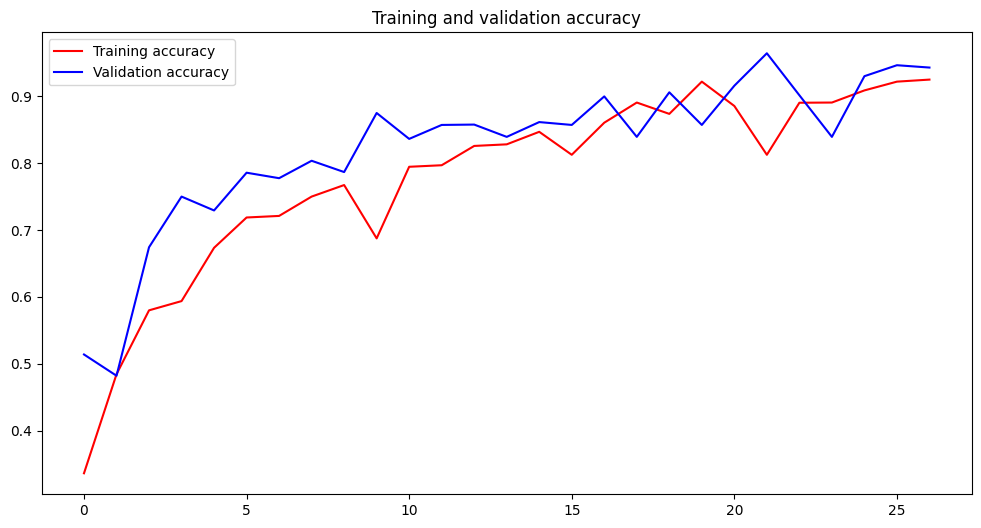

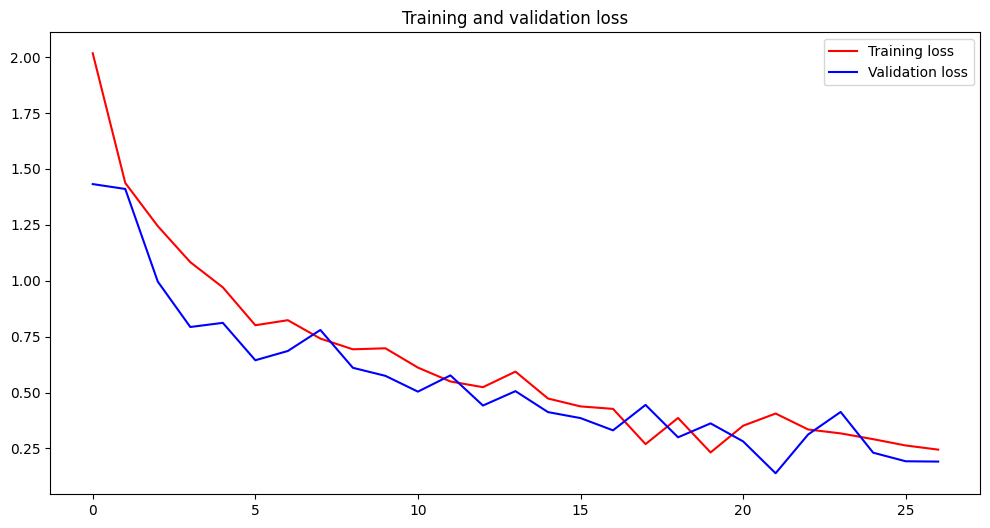

In [9]:
# Plotting Accuracy and Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(12, 6))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


# Part 10: Evaluating the Model

Finally, the model is evaluated on the test set to check its performance.


In [10]:
# Save the Model in Various Formats
model.export('saved_model')
model.save('model.keras')


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  132885092569456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132885092572272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132885092568400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132885092576144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132885092575440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132885092577904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132885092577200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132885092579664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132885092576848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132885092571568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132885092573328: T

In [11]:
!tensorflowjs_converter --input_format=keras model.keras tfjs_model

/bin/bash: line 1: tensorflowjs_converter: command not found


In [12]:
# Convert to TF-Lite
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


In [13]:
!pip install tensorflowjs
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, 'tfjs_model')


INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 840.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 25.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1
  Attempting uninstall: ml-dtypes
    Found existing installation: ml

failed to lookup keras version from the file,
    this is likely a weight only file


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
from tensorflow.keras.preprocessing import image
import numpy as np

# Load images for prediction, including subdirectories
def load_images_from_folder(folder):
    images = []
    for root, dirs, files in os.walk(folder):
        for filename in files:
            filepath = os.path.join(root, filename)
            if os.path.isfile(filepath):
                try:
                    img = image.load_img(filepath, target_size=(150, 150))
                    img_array = image.img_to_array(img)
                    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
                    images.append((filename, img_array))
                except Exception as e:
                    print(f"Error loading image {filename}: {e}")
    return images

# Path to the directory containing prediction images
pred_dir = '/content/drive/My Drive/data/validation'

# Load the images
prediction_images = load_images_from_folder(pred_dir)

# Check if images are loaded successfully
print(f"Loaded {len(prediction_images)} images for prediction.")


Loaded 3000 images for prediction.


In [3]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# Path to the directory containing prediction images
pred_dir = '/content/drive/My Drive/data/validation'

# Load images for prediction, including subdirectories
def load_images_from_folder(folder):
    images = []
    for root, dirs, files in os.walk(folder):
        for filename in files:
            filepath = os.path.join(root, filename)
            if os.path.isfile(filepath):
                try:
                    img = image.load_img(filepath, target_size=(150, 150))
                    img_array = image.img_to_array(img)
                    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
                    images.append((filepath, img_array))  # Store full path for correct label lookup
                except Exception as e:
                    print(f"Error loading image {filename}: {e}")
    return images

# Map directory names to labels
def get_correct_label(filepath):
    # Extract the label from the parent directory of the filename
    label = os.path.basename(os.path.dirname(filepath))
    label_map = {
        'Broccoli': 0,
        'Bitter_Gourd': 1,
        'Bean': 2,
        'Brinjal': 3,
        'Bottle_Gourd': 4,
        'Potato': 5,
        'Cabbage': 6,
        'Tomato': 7,
        'Cauliflower': 8,
        'Cucumber': 9,
    }
    return label_map.get(label, -1)  # Return -1 if label not found

# Load the images
prediction_images = load_images_from_folder(pred_dir)
print(f"Loaded {len(prediction_images)} images for prediction.")

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="model.tflite")  # Provide the correct path to your TFLite model
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

correct_predictions = 0
total_predictions = 0

for filepath, img_array in prediction_images:
    # Set the tensor to the model's input data
    interpreter.set_tensor(input_details[0]['index'], img_array)

    # Run the model
    interpreter.invoke()

    # Get the results
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Interpret the model's output
    predicted_label = np.argmax(output_data)
    correct_label = get_correct_label(filepath)

    print(f"Predicted label: {predicted_label}, Correct label: {correct_label}")
    print(f"Predicted output for {os.path.basename(filepath)}: {output_data}")

    if predicted_label == correct_label:
        correct_predictions += 1

    total_predictions += 1

accuracy = correct_predictions / total_predictions * 100
print(f"TF-Lite model accuracy: {accuracy:.2f}%")


Streaming output truncated to the last 5000 lines.
Predicted output for 1285.jpg: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Predicted label: 13, Correct label: -1
Predicted output for 1218.jpg: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Predicted label: 13, Correct label: -1
Predicted output for 1247.jpg: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Predicted label: 14, Correct label: -1
Predicted output for 1268.jpg: [[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 3.287952e-24 1.000000e+00]]
Predicted label: 13, Correct label: -1
Predicted output for 1349.jpg: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Predicted label: 13, Correct label: -1
Predicted output for 1241.jpg: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Predicted label: 13, Correct label: -1
Predicted output for 1361.jpg: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
P


# Part 14: Generating `requirements.txt`

Finally, a `requirements.txt` file is generated to document the dependencies required for this project.


In [4]:
# Generate requirements.txt
with open('requirements.txt', 'w') as f:
    f.write('\n'.join([
        'tensorflow==2.12.0',
        'tensorflowjs==4.4.0',
        'matplotlib==3.7.1',
        'numpy==1.23.5'
    ]))
